In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg as spla
from scipy import linalg
from scipy import sparse
import time

import finite
import timesteppers
import equations

In [2]:
def plot_2D(matrix):
    lim_margin = -0.05
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot()
    I, J = matrix.shape
    # matrix_mag = np.log10(np.abs(matrix))
    matrix_mag = matrix
    ax.pcolor(matrix_mag[::-1])
    ax.set_xlim(-lim_margin, I+lim_margin)
    ax.set_ylim(-lim_margin, J+lim_margin)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', 'box')
    plt.tight_layout()
    plt.show()

# Navier Stokes

In this project we first try to solve compressible Navier Stokes equations, modeling a shear KH instability. We also try to solve incompressible Navier Stokes for the same shear problem.

Specifically we try to model the instability of a stream of air moving in one direction through air with no initial velocity.

The governing equations are as follows (ignoring external forces):

$$\frac{\partial \rho}{\partial t} + u \cdot \nabla \rho = - \rho \nabla \cdot u$$

$$\frac{\partial u}{\partial t} + u \cdot \nabla u = - \frac{\nabla p}{\rho} + \frac{\mu}{\rho} (\nabla ^2 u + \frac{1}{3} \nabla(\nabla \cdot u))$$

$$\frac{\partial p}{\partial t} + u \cdot \nabla p - (\frac{\gamma p}{\rho} (\frac{\partial \rho}{\partial t} + u \cdot \nabla \rho)) = K \nabla ^2 (\frac{p}{\rho})$$

Here $u$ is the velocity (we try to solve in 2D), $\rho$ is the density, $p$ is pressure, $\mu$ is viscosity, $\gamma$ is the ratio of specific heats, $\kappa$ is thermal diffusivity, $K = \frac{\kappa M}{R}$ is a constant related to thermal diffusivity

## Simplified Compressible Navier Stokes

We can make a few simplifications to make these more feasible. In particular, if we assume density stays about constant, we can reduce these down to (treating density as constant):

$$\frac{\partial u}{\partial t} - \frac{\mu}{\rho} \nabla ^2 u + \frac{\nabla p}{\rho} = - u \cdot \nabla u$$

$$\frac{\partial p}{\partial t} - \frac{K}{\rho} \nabla ^2 p = - u \cdot \nabla p - \gamma p \nabla \cdot u$$

The following is the code of the linear and nonlinear terms of these two equations:


In [3]:
class CompressibleNavierStokes:
    def __init__(self, u, v, p, mu, kappa, gamma, rho, spatial_order, domain):
        self.X = timesteppers.StateVector([u, v, p])
        dx = finite.DifferenceUniformGrid(1, spatial_order, domain.grids[0], axis=0)
        dy = finite.DifferenceUniformGrid(1, spatial_order, domain.grids[1], axis=1)

        d2x = finite.DifferenceUniformGrid(2, spatial_order, domain.grids[0], axis=0)
        d2y = finite.DifferenceUniformGrid(2, spatial_order, domain.grids[1], axis=1)

        self.N = len(u)

        I = sparse.eye(self.N)
        Z = sparse.csr_matrix((self.N, self.N))

        self.M = sparse.bmat([[I, Z, Z],
                              [Z, I, Z],
                              [Z, Z, I]])
        
        self.L = (1/rho) * sparse.bmat([[-mu * d2x.matrix, -mu * d2y.matrix, dx.matrix],
                                        [-mu * d2x.matrix, -mu * d2y.matrix, dy.matrix],
                                        [Z, Z, -kappa * (d2x.matrix + d2y.matrix)]])

        def F(X):
            X.scatter()
            u = X.variables[0]
            v = X.variables[1]
            p = X.variables[2]

            r1 = -u * (dx @ u)
            r2 = -v * (dy @ v)
            r3 = -(u * (dx @ p) + v * (dy @ p)) - gamma * p * (dx @ u + dy @ v)

            return np.vstack((r1, r2, r3))
        self.F = F

        def J(X):
            X.scatter()
            u = X.variables[0]
            v = X.variables[1]
            p = X.variables[2]

            # t1 = np.tile(u, (self.N, 1)).T
            # print(t1.shape)
            m1 = dx.matrix.multiply(u)
            r1 = -m1 - dx @ u #sparse.diags(dx @ u)

            # t2 = np.tile(v, (self.N, 1)).T
            m2 = dy.matrix.multiply(v)
            r2 = -m2 - dy @ v # sparse.diags(dy @ v)

            r31 = -(dx @ p) - gamma * p * m1
            r32 = -(dy @ p) - gamma * p * m2

            # t3 = np.tile(p, (self.N, 1)).T

            m3 = dx.matrix.multiply(p)
            m4 = dy.matrix.multiply(p)

            r33 = - (u * m3 + v * m4) - gamma * (dx @ u + dy @ v)

            return sparse.bmat([[r1, Z, Z],
                                [Z, r2, Z],
                                [r31, r32, r33]])
        self.J = J

## Initial Conditions

First we need to consider what initial conditions we will set. For this we set a horizontal tube of velocity in one direction, with velocity quickly dropping off towards zero as we move away from the inner tube:

<IPython.core.display.Javascript object>


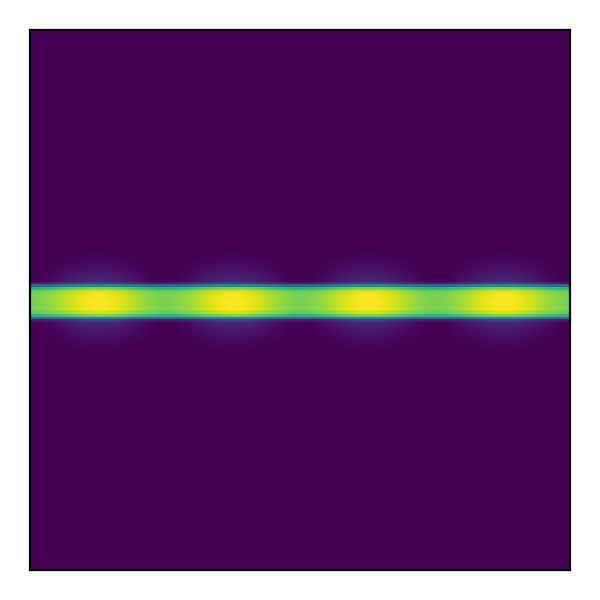

In [4]:
resolution = 200
alpha = 0.25
spatial_order = 2

# grid_x = finite.UniformNonPeriodicGrid(resolution,(0,2*np.pi))
grid_x = finite.UniformPeriodicGrid(resolution,2*np.pi)
grid_y = finite.UniformPeriodicGrid(resolution,2*np.pi)
domain = finite.Domain([grid_x, grid_y])
x, y = domain.values()

u = np.zeros(domain.shape)
v = np.zeros(domain.shape)
p = np.zeros(domain.shape)
reynolds = 5e4
# viscosity
mu = 1 / reynolds
nu = mu
# thermal diffusivity
kappa = 1.4
# ratio of specific heats
gamma = 5/3
# choose a constant density
rho = 1

radius = 0.2
# smaller number here means faster dropoff
dropoff = 0.04
IC_vx = 1/2 * (np.tanh(((y - np.pi)-radius)/dropoff) - np.tanh(((y - np.pi)+radius)/dropoff))
u[:] = IC_vx.T
# u[:] = 1

# vertical perturbation
IC_vy = .5 * np.sin(2*x) * np.exp(-((y) - np.pi)**2/0.2)
v[:] = IC_vy.T

p[:] = 0.1

# plot magnitude squared of velocity
plot_2D(u * u + v * v)
plt.show()

/opt/homebrew/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


<IPython.core.display.Javascript object>


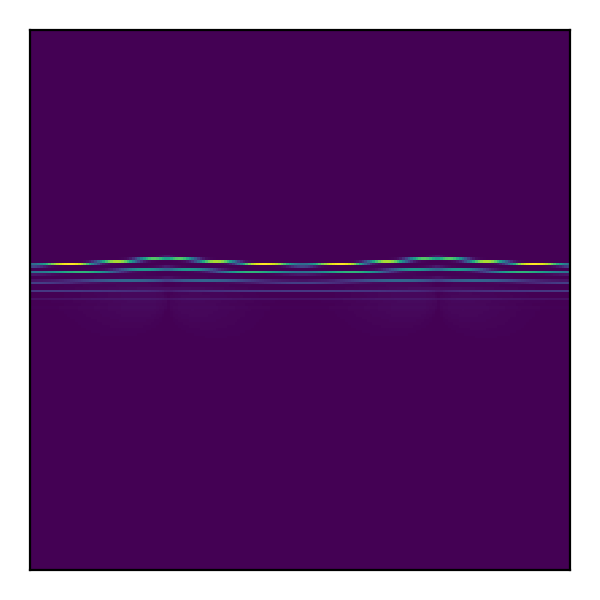

In [6]:
eq = CompressibleNavierStokes(u, v, p, mu, kappa, gamma, rho, spatial_order, domain)
# diff = equations.IncompressibleNavierStokes(u, v, p, nu, spatial_order, domain)

dt = alpha*grid_y.dx

ts = timesteppers.CNAB(eq)

ts.evolve(dt, 1-1e-5)

# fig, ax = plt.subplots()
# ln = plt.plot(x, u, 'r-')
# plt.show()
# while diff.t < .03*np.pi/4 - 1e-5:
#     diff.step(dt)

# print(f"dt: {dt}")
# print(f"iter: {diff.iter}")

# print(u)

# plot_2D(p)
plot_2D(u * u + v * v)
plt.show()

## Incompressible Navier Stokes

Since the above did not quite work, we tried to do incompressible Navier Stokes. In this setup, density is constant. We make use of this fact to turn the density equation from:

$$\frac{\partial \rho}{\partial t} + u \cdot \nabla \rho = - \rho \nabla \cdot u$$

to:

$$\nabla \cdot u = 0$$

And keep the other equation:

$$\frac{\partial u}{\partial t} - \frac{\mu}{\rho} \nabla ^2 u + \frac{\nabla p}{\rho} = - u \cdot \nabla u$$

Also note the fact that the above equation is essentially the 2D Viscous Burgers equation with a pressure term.

The challenge of incompressible Navier Stokes is that there is no explicit $\frac{\partial p}{\partial t}$ equation. Instead, pressure acts as a constraint that we need to satisfy at each timestep.

In [ ]:
class IncompressibleNavierStokes:
    def __init__(self, u, v, p, nu, spatial_order, domain):
        self.t = 0
        self.iter = 0

        self.u = u
        self.v = v
        self.p = p
        self.X = timesteppers.StateVector([u, v, p])
        self.dx = finite.DifferenceUniformGrid(1, spatial_order, domain.grids[0], axis=0)
        self.dy = finite.DifferenceUniformGrid(1, spatial_order, domain.grids[1], axis=1)

        self.d2x = finite.DifferenceUniformGrid(2, spatial_order, domain.grids[0], axis=0)
        self.d2y = finite.DifferenceUniformGrid(2, spatial_order, domain.grids[1], axis=1)

        self.N = len(u)

        diffx = VBDiffusionX(u, v, nu, self.d2x)
        diffy = VBDiffusionY(u, v, nu, self.d2y)
        self.diffusion_ts_x = timesteppers.CrankNicolson(diffx, 0)
        self.diffusion_ts_y = timesteppers.CrankNicolson(diffy, 1)

        adv_x = AdvectionX(u, v, self.dx, self.dy)
        adv_y = AdvectionY(u, v, self.dx, self.dy)
        self.advection_ts_x = timesteppers.RK22(adv_x)
        self.advection_ts_y = timesteppers.RK22(adv_y)

    def step(self, dt):
        d = (self.dx @ self.u + self.dy @ self.v)

        self.advection_ts_y.step(dt/2)
        self.advection_ts_x.step(dt/2)
        self.diffusion_ts_y.step(dt)
        self.diffusion_ts_x.step(dt)
        self.advection_ts_x.step(dt/2)
        self.advection_ts_y.step(dt/2)

        # u and v are currently U*
        LHS = (self.d2x.matrix + self.d2y.matrix)
        LU = spla.splu(LHS.tocsc(), permc_spec='NATURAL')
        
        RHS = -(self.dx @ self.u + self.dy @ self.v)
        # plot_2D(self.dy.matrix.toarray())

        p = LU.solve(RHS)
        self.p[:] = p

        self.u += self.dx @ p
        self.v += self.dy @ p

        self.t += dt
        self.iter += 1